<a href="https://colab.research.google.com/github/kimkynningsrud/MasterThesis2024/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using DTW - Master Thesis 2024

To do:
- Make function to slice all data to similar timeframe
- Implement other functions to measure dataset similarity
- Implement transfer learning framework

## Importing Packages

In [229]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
from scipy.spatial.distance import euclidean

## Importing Data
Here we also make sure the datasets are on the correct format to be able to go through the following functions.
Requirements:
  - Temporal sequence of interest should be in the last column.

In [230]:
# Stock prices dataset
stock_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/indexData.csv?token=GHSAT0AAAAAACML34ERF76CZOWCJEXGGYJYZNPUR6A"
stock_prices = pd.read_csv(stock_prices_url)

stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])  # Ensure the 'Date' column is in datetime format
stock_prices = stock_prices[stock_prices['Index'] == '399001.SZ']

# gold prices dataset
gold_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Gold%20Price.csv?token=GHSAT0AAAAAACML34EQS56T2DT6QGLUZDE4ZNPRLKQ"
gold_prices = pd.read_csv(gold_prices_url)

# petrolium prices dataset
petrolium_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/PET_PRI_GND_DCUS_NUS_W.csv?token=GHSAT0AAAAAACML34ERPSSHRB7KWYAFCJ3MZNPRLVQ"
petrolium_prices = pd.read_csv(petrolium_prices_url)

#other datasets also go here. If the list of datasets grows too long, consider urls in list.


In [231]:
stock_prices.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
52127,399001.SZ,1997-08-22,4190.759766,4278.299805,4168.089844,4242.060059,4242.012695,0.0
52128,399001.SZ,1997-08-25,4247.709961,4364.459961,4247.089844,4363.029785,4362.980957,0.0
52129,399001.SZ,1997-08-26,4373.529785,4422.500000,4346.979980,4386.520020,4386.471191,0.0
52130,399001.SZ,1997-08-27,4374.020020,4411.140137,4339.459961,4408.390137,4408.340332,0.0
52131,399001.SZ,1997-08-28,4408.580078,4468.870117,4373.450195,4438.319824,4438.270020,0.0


In [232]:
gold_prices.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [233]:
petrolium_prices.head()

,Date,A1,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1
0,01/02/1995,1.127,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104
1,01/09/1995,1.134,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102
2,01/16/1995,1.126,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100
3,01/23/1995,1.132,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095
4,01/30/1995,1.131,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090


In [234]:
# moving the "A1" to the back of the dataframe as this is needed for the DTW. "A1" is the temporal column of interest.
A1col = petrolium_prices.pop("A1")
petrolium_prices.insert(len(petrolium_prices.columns), "A1", A1col)
petrolium_prices.head()

,Date,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1,A1
0,01/02/1995,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104,1.127
1,01/09/1995,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102,1.134
2,01/16/1995,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100,1.126
3,01/23/1995,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095,1.132
4,01/30/1995,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090,1.131


## Pre-processing

In [235]:
def convert_dates(df, date_column='Date', date_format=None):
    """
    Converts the date column to datetime format.

    :param df: Pandas DataFrame containing the financial data.
    :param date_column: Name of the column containing date information.
    :param date_format: The format of the dates in the date column. If None, pandas will infer the format.
    :return: DataFrame with the converted date column.
    """
    df[date_column] = pd.to_datetime(df[date_column], format=date_format, errors='coerce')
    return df

def trim_dataset_to_timeframe(df, date_column='Date', start_year=2015, end_year=2021):
    """
    Trims the dataset to include data only between the specified start and end years.

    :param dataset: Pandas DataFrame containing the data.
    :param date_column: The name of the column containing the date information.
    :param start_year: The start year for the timeframe.
    :param end_year: The end year for the timeframe.
    :return: Trimmed DataFrame.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the dataset based on the date range
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return df


def handle_missing_values(df, names):
    """
    Detects and removes missing values.

    :param df: Pandas DataFrame.
    :return: DataFrame after removing missing values.
    """
    NA_values_before = df.isna().sum().sum()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    NA_values_after = df.isna().sum().sum()

    print(f'There are {NA_values_before} NA values in the {names} dataset. {NA_values_after} after removing them.')

    return df

def scale_data(df, date_column='Date'):
    """
    Scales numerical columns except the date column.

    :param df: Pandas DataFrame.
    :param date_column: Name of the column containing date information to exclude from scaling.
    :return: Scaled DataFrame.
    """
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns.drop(date_column, errors='ignore')  # Exclude date column if present
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [236]:
datasets = [
    (gold_prices, None, "Gold Prices"),  # Standard date format assumed
    (stock_prices, None, "Stock Prices"),  # Standard date format assumed
    (petrolium_prices, '%m/%d/%Y', "Petrolium Prices")  # Custom date format
]

# Preprocessing all datasets
preprocessed_datasets = []

for df, date_format, names in datasets:
    preprocessed_df = convert_dates(df, date_format=date_format)
    preprocessed_df = trim_dataset_to_timeframe(df)
    preprocessed_df = handle_missing_values(preprocessed_df, names)
    preprocessed_df = scale_data(preprocessed_df)

    preprocessed_datasets.append(preprocessed_df)



There are 0 NA values in the Gold Prices dataset. 0 after removing them.
There are 12 NA values in the Stock Prices dataset. 0 after removing them.
There are 0 NA values in the Petrolium Prices dataset. 0 after removing them.


<ipython-input-235-259fbf11ded1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-235-259fbf11ded1>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
<ipython-input-235-259fbf11ded1>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
<ipython

## Plotting after preprocessing

[Text(0.5, 1.0, 'Petrolium Price')]

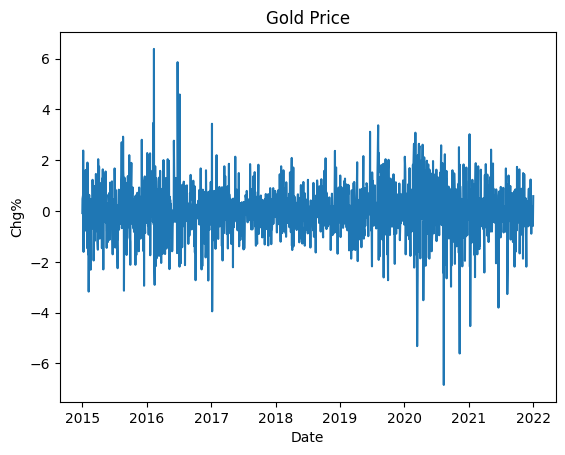

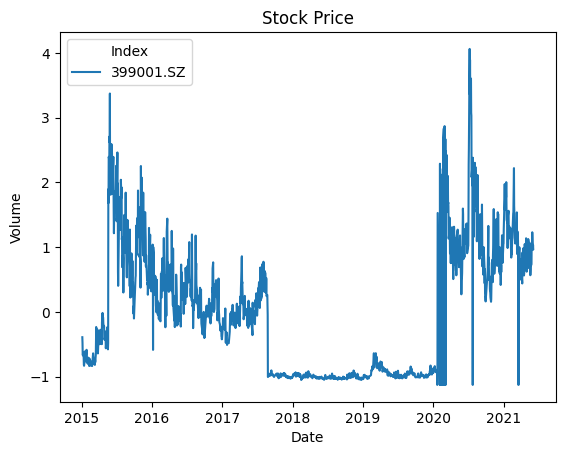

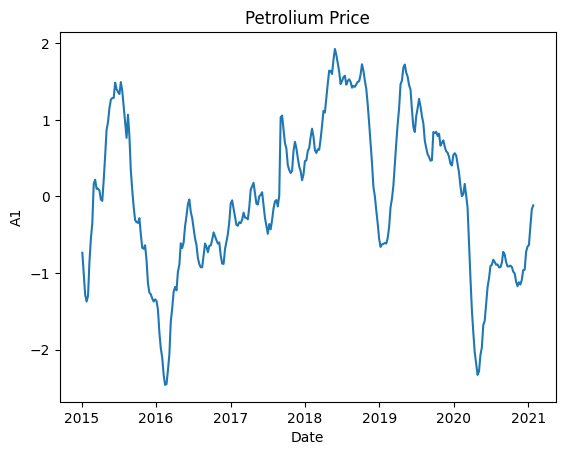

In [243]:
# plotting gold prices
plt.figure()
sns.lineplot(preprocessed_datasets[0], x='Date', y='Chg%').set(title="Gold Price")

# plotting stock prices
plt.figure()
sns.lineplot(preprocessed_datasets[1], x='Date', y='Volume', hue='Index').set(title="Stock Price")

# plotting petrolium prices
plt.figure()
sns.lineplot(preprocessed_datasets[2], x='Date', y='A1').set(title="Petrolium Price")

## Dynamic Time Warping (DTW)

In [238]:
def compare_datasets_with_dtw(datasets):
    """
    Compares each dataset to every other dataset using Dynamic Time Warping (DTW).
    Assumes the column of interest is the last one in each dataset.

    :param datasets: List of Pandas DataFrames, each representing a time series dataset.
    :return: A matrix of DTW distances between each pair of datasets.
    """
    n = len(datasets)
    dtw_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[i].iloc[:, -1].values
            series_j = datasets[j].iloc[:, -1].values

            # Calculate DTW distance
            distance = dtw.distance(series_i, series_j)
            dtw_matrix[i, j] = dtw_matrix[j, i] = distance

    return dtw_matrix

dtw_matrix = compare_datasets_with_dtw(preprocessed_datasets)


In [239]:
dataset_names = [name for _, _, name in datasets] # Define the names in list for later use

dtw_df_with_names = pd.DataFrame(dtw_matrix.round(2), index=dataset_names, columns=dataset_names)
dtw_df_with_names

,Gold Prices,Stock Prices,Petrolium Prices
Gold Prices,0.00,39.03,41.11
Stock Prices,39.03,0.00,17.47
Petrolium Prices,41.11,17.47,0.00
